## Redes Neuronales Informadas por Física
### Carrera de Especialización en Inteligencia Artificial - FIUBA

## Trabajo Práctico Nº4

### 3º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |
| Ezequiel Maudet       | eze.maudet@gmail.com      | a1812   |
| Federico Zoya         | fzoya33@gmail.com         | a1828   |

### Flow in a Square Cavity (Lid-Driven Cavity)

#### Description:

This is a standard test case to verify the accuracy of numerical methods solving the incompressible Navier-Stokes equations. The domain is $\Omega = [0,1] \times [0,1]$

Governing equations in steady state:

- Momentum equation (vector form): $(\mathbf{u} \cdot \nabla) \mathbf{u} = - \nabla p + \frac{1}{Re} \nabla^2 \mathbf{u}$ in $\Omega$

- Continuity equation (incompressibility): $\nabla \cdot \mathbf{u} = 0$ in $\Omega$

Boundary conditions:  

- No-slip condition on the side and bottom walls (velocity zero).
- Top wall moves at a constant velocity in the ( +x ) direction.

### 1. LIBRARIES AND GENERAL PARAMETERS

In [1]:
import scipy.io                     # for matlab files manipulation
import os                           # for files manipulation
import pandas as pd                 # for data manipulation
import numpy as np                  # for data manipulation
import matplotlib.pyplot as plt     # for plotting


import torch                        # For neural networks models
# from tqdm import tqdm               # For progress bar

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
import random

def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # In general seed PyTorch operations
    torch.manual_seed(seed)

    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)

    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(seed)

    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True

    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

set_seed(42)

#### 2. PROBLEM DEFINITION

In [4]:
# Domain definition
x_min = 0
x_max = 1

y_min = 0
y_max = 1

In [5]:
# Velocity boundary conditions

U_bc = [0, 0, 0, 1]     # [left, right, bot, top]
V_bc = [0, 0, 0, 0]     # [left, right, bot, top]


### 3. GROUND TRUTH SOLUTION

We load the reference solution obtained by finite element analysis.

In [6]:
folder = 'Re-100'

# Read all files in folder
files = os.listdir(folder)

# Filter only MatLab files
mat_files = [f for f in files if f.endswith('.mat')]

print(mat_files)

['pressure.mat', 'velocity.mat']


In [7]:
def mat2df(mat_file):
    """
    Load a .mat file and convert its variables into a pandas DataFrame.
    
    Parameters:
    - mat_file: str, path to the .mat file
    
    Returns:
    - df: pandas.DataFrame with variables as columns
    """
    file_path = os.path.join(folder, mat_file)
    data = scipy.io.loadmat(file_path)
    variables = {}
    for key in data:
        if not key.startswith('__'):
            value = data[key]
            # Convert scalar values to list
            if np.isscalar(value):
                variables[key] = [value]
            elif isinstance(value, np.ndarray):
                # Flatten array if necessary
                if value.ndim == 1:
                    variables[key] = value
                else:
                    variables[key] = value.flatten()
    # Create DataFrame
    df = pd.DataFrame(variables)
    return df

In [8]:
df_pressure = mat2df(mat_files[0])
df_pressure.head(5)

,x,y,z,p
0,0.00,0.0,0.0,0.000000
1,0.01,0.0,0.0,0.000016
2,0.02,0.0,0.0,0.000013
3,0.03,0.0,0.0,-0.000038
4,0.04,0.0,0.0,-0.000131


In [9]:
df_velocity = mat2df(mat_files[1])
df_velocity.head(5)

,x,y,z,u,v,w
0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.01,0.0,0.0,0.0,0.0,0.0
2,0.02,0.0,0.0,0.0,0.0,0.0
3,0.03,0.0,0.0,0.0,0.0,0.0
4,0.04,0.0,0.0,0.0,0.0,0.0


In [10]:
df_fem = pd.merge(df_velocity[['x', 'y', 'u', 'v']], df_pressure[['x', 'y', 'p']],  on=['x', 'y'], how='inner')
df_fem.head(5)

,x,y,u,v,p
0,0.00,0.0,0.0,0.0,0.000000
1,0.01,0.0,0.0,0.0,0.000016
2,0.02,0.0,0.0,0.0,0.000013
3,0.03,0.0,0.0,0.0,-0.000038
4,0.04,0.0,0.0,0.0,-0.000131


In [11]:
ndata = df_fem.shape[0]
ndata

20201

Contour plot for the FEM results:

In [12]:
from scipy.interpolate import griddata

def contourplot_df(df, coord_cols, value_col, levels=50):
    # Extract node coordinates and nodal values
    points = df[['x', 'y']].values
    values = df[value_col].values

    # Create grid for plotting
    grid_x, grid_y = np.mgrid[
        points[:,0].min():points[:,0].max():100j,
        points[:,1].min():points[:,1].max():100j
    ]

    # Interpolate nodal values onto grid
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    # Plot the contour
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=levels, cmap='turbo')
    plt.colorbar(contour)
    plt.title(f'FEM results contour plot of {value_col}')
    plt.xlabel(coord_cols[0])
    plt.ylabel(coord_cols[1])
    plt.axis('equal')
    # plt.show()

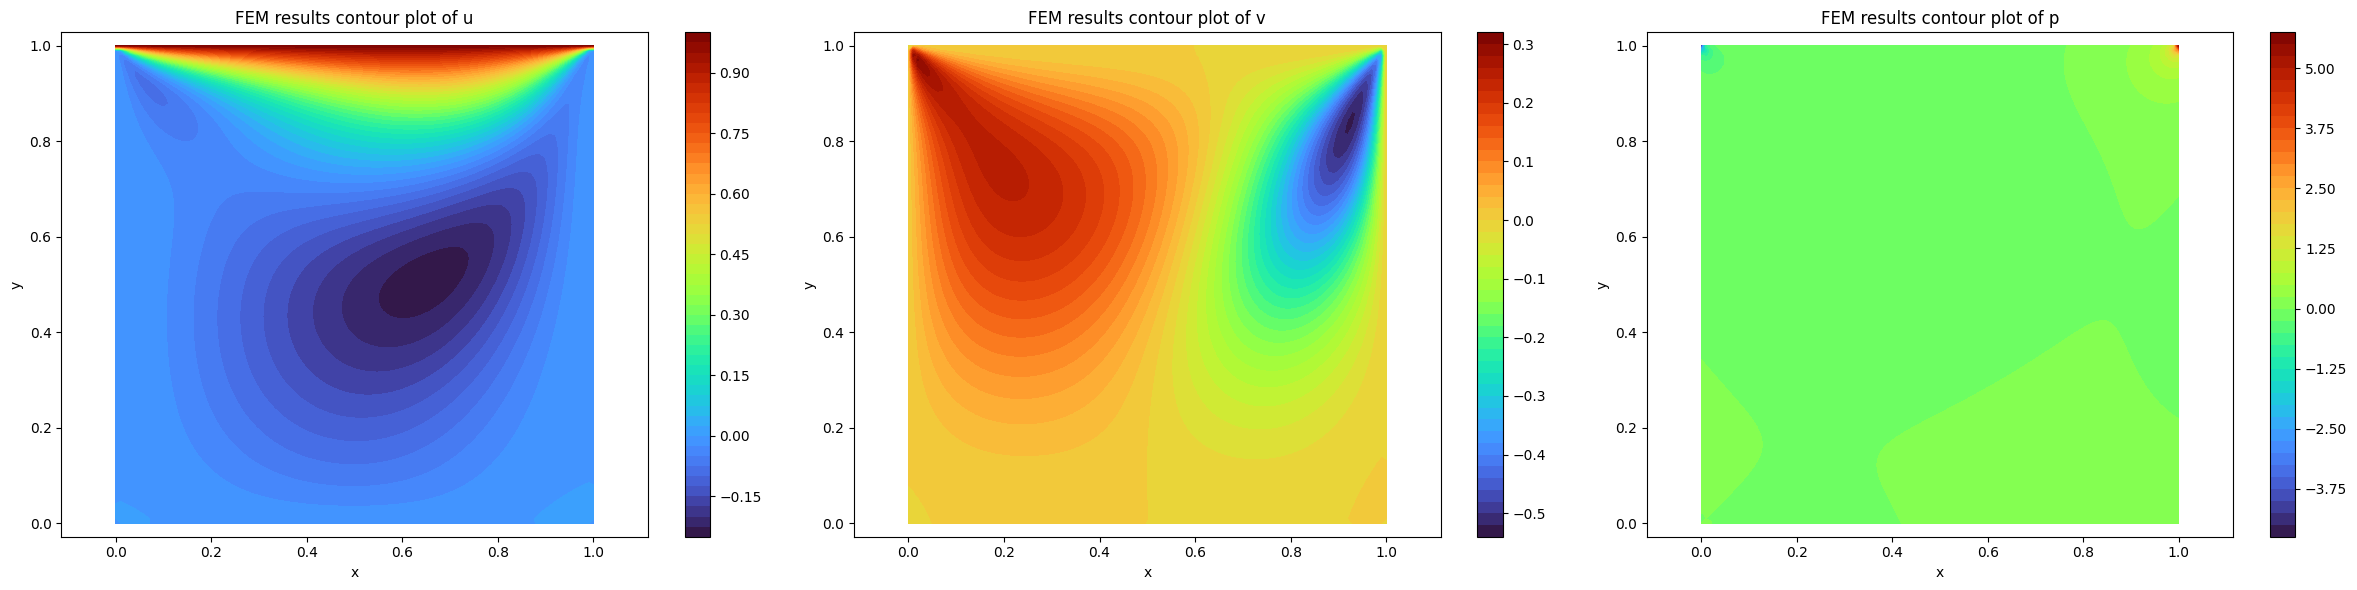

In [13]:
variables = ['u', 'v', 'p']
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, var in enumerate(variables):
    plt.sca(axes[i])
    contourplot_df(df_fem, ['x', 'y'], var)
    
for i, var in enumerate(variables):
    axes[i].set_title(f'FEM results contour plot of {var}')

plt.tight_layout()
plt.show()

### 4. DATA GENERATION

In [14]:
tags = ["Domain", "BoundaryConditions"]
isData = True           # Flag to indicate whether the analysis would use labelled data or not
nsamples = 25           # Number of labelled data to be used in the analysis

#### 4.1 Collocation points

In [15]:
def get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc, n_eq, strategy = 'random'):
    """
    Generate collocation points for domain and boundary conditions.

    Args:
    - x_min, x_max: Minimum and maximum values for x-axis.
    - y_min, y_max: Minimum and maximum values for y-axis.
    - n_pde: Number of points for PDE domain.
    - n_bc: Number of points for each boundary.
    - strategy: Method to choose collocation points distribution.

    Returns:
    - X_dom_tensor: Tensor containing the domain points.
    - X_bc_tensor: Tensor containing the boundary points.
    """
    if strategy == 'uniform':
        # Adjust n_pde for uniform case
        n_pde_sqrt = int(np.sqrt(n_pde))
        n_pde = n_pde_sqrt**2
        
        # Crear una cuadrícula 2D de tamaño n_pde x n_pde
        x_vals = torch.linspace(x_min, x_max, n_pde_sqrt, device=device)
        y_vals = torch.linspace(y_min, y_max, n_pde_sqrt, device=device)
        X_grid, Y_grid = torch.meshgrid(x_vals, y_vals, indexing='ij')

        # Aplanar las mallas en vectores 1D si quieres usar en los datos
        x_dom = X_grid.reshape(-1)
        y_dom = Y_grid.reshape(-1)    
        
        y_left = torch.linspace(y_min, y_max, n_bc, device = device)
        y_right = y_left.clone()
        
        x_bot = torch.linspace(x_min, x_max, n_bc, device = device)
        x_top = x_bot.clone()
    
    else:

        delta_x = x_max - x_min
        delta_y = y_max - y_min

        npoints = n_pde + 2 * n_bc

        if strategy == 'random':
            rand_aux = torch.rand((npoints, 2), device = device)    
        elif strategy == 'lhs':
            from scipy.stats.qmc import LatinHypercube
            rand_aux = torch.tensor(LatinHypercube(d=2).random(npoints), device=device)
        else:
            raise ValueError("Incorrect strategy. Choose 'uniform', 'random', or 'lsh'.")

        x_dom = (x_min + delta_x * rand_aux[:n_pde, 0]).to(torch.float32)
        y_dom = (y_min + delta_y * rand_aux[:n_pde, 1]).to(torch.float32)
            
        y_left = (y_min + delta_y * rand_aux[n_pde:(n_pde + n_bc), 1]).to(torch.float32)
        y_right = (y_min + delta_y * rand_aux[-n_bc:, 1]).to(torch.float32)
        
        x_bot = (x_min + delta_x * rand_aux[n_pde:(n_pde + n_bc), 0]).to(torch.float32)
        x_top = (x_min + delta_x * rand_aux[-n_bc:, 0]).to(torch.float32)


    x_left = x_min * torch.ones(n_bc)
    x_right = x_max * torch.ones(n_bc)
    
    y_bot = y_min * torch.ones(n_bc)
    y_top = y_max * torch.ones(n_bc)

    # Combine all domain points
    X_dom_tensor = torch.stack((x_dom, y_dom), dim=1)

    # Combine all boundary points
    X_bc_tensor = torch.cat([
                torch.stack((x_left, y_left), dim=1),
                torch.stack((x_right, y_right), dim=1),
                torch.stack((x_bot, y_bot), dim=1),
                torch.stack((x_top, y_top), dim=1),
            ], axis=0)

    Y_dom_tensor = torch.zeros((n_pde, n_eq), device=device)

    return X_dom_tensor, Y_dom_tensor, X_bc_tensor

In [16]:
from torch.utils.data import TensorDataset

# Number of collocation points
n_pde = 10_000       # for domain
n_bc = 1_000         # for Boundary conditions

X_dom_tensor, Y_dom_tensor, X_bc_tensor = get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc//4, n_eq = 3, strategy = 'lhs')

También generamos un dataset reducido de 1_000 puntos para hacer ajustar hiper-parámetros más rápidamente.

In [17]:
sampler_size = 0.10

X_dom_sampler, Y_dom_sampler, _ = get_collocation_points(x_min, x_max, y_min, y_max, int(sampler_size * n_pde), n_bc//4, n_eq = 3, strategy = 'lhs')

#### 4.2 Boundary Conditions

In [18]:
u_tensors = [ui * torch.ones((n_bc // 4, 1)) for ui in U_bc]
v_tensors = [vi * torch.ones((n_bc // 4, 1)) for vi in V_bc]

u_bc_tensor = torch.cat(u_tensors, axis=0)
v_bc_tensor = torch.cat(v_tensors, axis=0)

Y_bc_tensor = torch.cat([u_bc_tensor, v_bc_tensor], dim=1)

Adicionalmente añadimos la condición de presión nula en el origen de coordenadas directamente en el entrenamiento.

#### 4.3 Datasets generation

In [19]:
ds = []     # Initialize list of dataset objects

ds.append(TensorDataset(X_dom_tensor, Y_dom_tensor))
ds.append(TensorDataset(X_bc_tensor, Y_bc_tensor))

ds_sampler = []
ds_sampler.append(TensorDataset(X_dom_sampler, Y_dom_sampler))
ds_sampler.append(TensorDataset(X_bc_tensor, Y_bc_tensor))

#### 4.4 Labelled data

In [20]:
if isData:
    tags.append("LabelledData")

    def get_bounded_data(box_size, omega=None):
        sign_list = [-1, 1]
        x_min_box, x_max_box = [0.5 * (x_min + x_max) + sgn * 0.5 * box_size * (x_max - x_min) for sgn in sign_list]
        y_min_box, y_max_box = [0.5 * (y_min + y_max) + sgn * 0.5 * box_size * (y_max - y_min) for sgn in sign_list]

        # Extraer coordenadas y valores
        points = df_fem[['x', 'y']].values
        values = df_fem[['u', 'v', 'p']].values

        # Crear grid
        n_x = n_y = int(np.sqrt(nsamples))
        grid_x, grid_y = np.mgrid[
            x_min_box:x_max_box:n_x*1j,
            y_min_box:y_max_box:n_y*1j
        ]

        # Interpolar nodos en la grilla
        grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

        if omega is not None:  # Añadir ruido gaussiano
            filtered_df = df_fem[
                (df_fem['x'] >= x_min) & (df_fem['x'] <= x_max) &
                (df_fem['y'] >= y_min) & (df_fem['y'] <= y_max)
            ]

            # Obtener valores máximos en valor absoluto de 'u', 'v', 'p'
            max_values = [
                filtered_df.loc[filtered_df['u'].abs().idxmax(), 'u'],
                filtered_df.loc[filtered_df['v'].abs().idxmax(), 'v'],
                filtered_df.loc[filtered_df['p'].abs().idxmax(), 'p']
            ]

            # Añadir ruido en cada componente
            for i in range(grid_z.shape[-1]):
                grid_z[:, :, i] += omega * max_values[i] * np.random.normal(0, 1, (n_x, n_y))

        # Preparar datos para Torch
        grid_xy = np.column_stack((grid_x.ravel(), grid_y.ravel()))
        grid_z = grid_z.reshape(-1, 3)

        X_data = torch.from_numpy(grid_xy).float().to(device)
        Y_data = torch.from_numpy(grid_z).float().to(device)

        return TensorDataset(X_data, Y_data)

    def copy_and_append(ds, item):
        new_ds = ds.copy()
        new_ds.append(item)
        return new_ds
    
    ds_25 = copy_and_append(ds, get_bounded_data(0.25))
    ds_50 = copy_and_append(ds, get_bounded_data(0.50))
    ds_75 = copy_and_append(ds, get_bounded_data(0.75))
    
    ds_25_noisy = copy_and_append(ds, get_bounded_data(0.25, omega = 0.01))
    ds_50_noisy = copy_and_append(ds, get_bounded_data(0.50, omega = 0.01))
    ds_75_noisy = copy_and_append(ds, get_bounded_data(0.75, omega = 0.01))
    
    ds_sampler_25 = copy_and_append(ds_sampler, get_bounded_data(0.25))

#### 4.5 Plot grid

In [21]:
# Dictionary of dataset objects
datasets_25 = dict(zip(tags, ds_25))
datasets_50 = dict(zip(tags, ds_50))
datasets_75 = dict(zip(tags, ds_75))

datasets_25_noisy = dict(zip(tags, ds_25_noisy))
datasets_50_noisy = dict(zip(tags, ds_50_noisy))
datasets_75_noisy = dict(zip(tags, ds_75_noisy))

sampler_25 = dict(zip(tags, ds_sampler_25))

In [22]:
def plot_grid(dataset, title = None):
    # Plot the locations of the collocation points in the space domain
    X_dom = (dataset["Domain"][:][0]).data.cpu().numpy()
    X_bc = (dataset["BoundaryConditions"][:][0]).data.cpu().numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_dom[:,0], X_dom[:, 1], s=4, c='r', label=f'N_dom={len(X_dom)}')
    ax.scatter(X_bc[:, 1:2], X_bc[:, 0:1], s=4, c='b', label=f'N_bc={len(X_bc)}')
    if isData:
        X_data = (dataset["LabelledData"][:][0]).data.cpu().numpy()
        ax.scatter(X_data[:, 0], X_data[:, 1], s=30, c='g', label=f'N_Data={len(X_data)}', marker='*')
    ax.legend()
    plt.xlabel('X-coord')
    plt.ylabel('Y-coord')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    if title is not None:
        plt.title(title)
    plt.show()

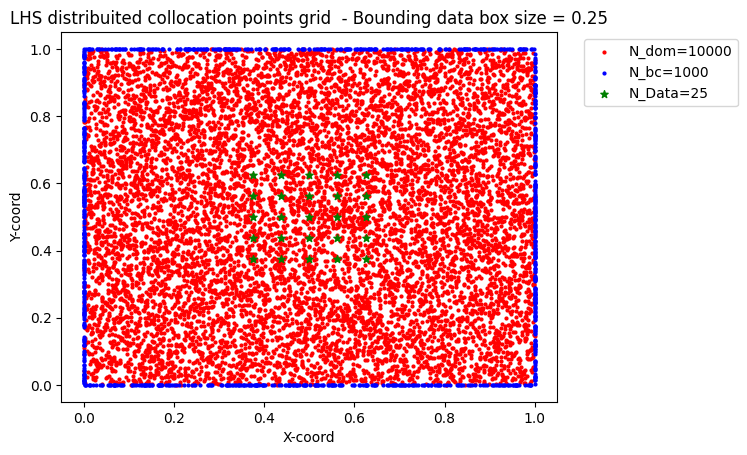

In [23]:
plot_grid(datasets_25, title='LHS distribuited collocation points grid  - Bounding data box size = 0.25')

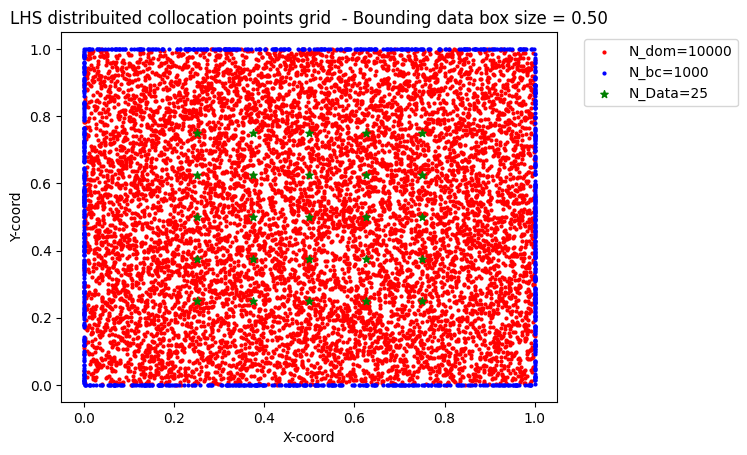

In [24]:
plot_grid(datasets_50, title='LHS distribuited collocation points grid  - Bounding data box size = 0.50')

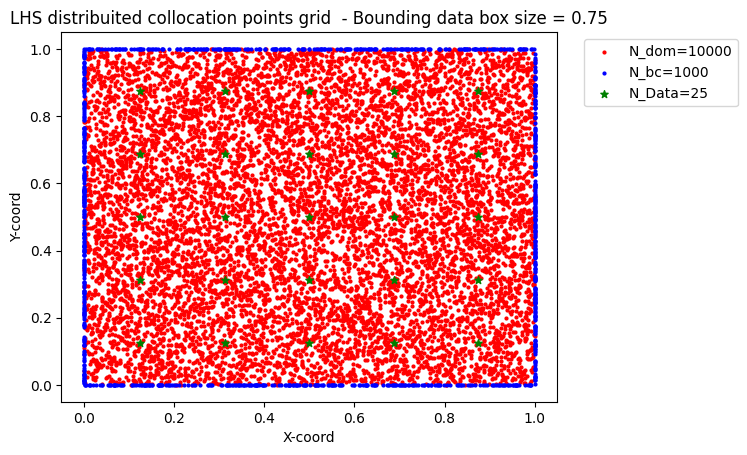

In [25]:
plot_grid(datasets_75, title='LHS distribuited collocation points grid  - Bounding data box size = 0.75')

### 5. PINN IMPLEMENTATION

Implementamos la solución usando PyTorch.

#### 5.1 Model architecture

Definimos una FC NN que toma las coordenadas espaciales *(x,y)* como inputs y devuelve los campos velocidades *u*,*v* y presión como outputs.

- **INPUTS**:
    1. Position vector x-component *x*
    2. Position vector x-component *x*

- **OUTPUTS**:
    1. Velocity vector x-component *u*
    2. Velocity vector y-component *v*
    3. Pressure scalar *p*

In [ ]:
import torch.nn as nn
import torchinfo as torchinfo

# Neural Network
class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters.Device
        self.Xmin = model_parameters.Xmin
        self.Xmax = model_parameters.Xmax
        self.Ymin = model_parameters.Ymin
        self.Ymax = model_parameters.Ymax
        self.Reynolds = model_parameters.Reynolds
        self.InputDimensions = model_parameters.InputDimensions
        self.OutputDimensions = model_parameters.OutputDimensions
        self.NumberOfNeurons = model_parameters.NumberOfNeurons
        self.NumberOfHiddenLayers = model_parameters.NumberOfHiddenLayers
        self.ActivationFunction = model_parameters.ActivationFunction
        self.Bias = model_parameters.Bias
        self.Lambdas = model_parameters.Lambdas
        
        # Input layer
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        # Hidden layers
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons, bias = self.Bias) for _ in range(self.NumberOfHiddenLayers-1)])  # The input-layer is considered as hidden
        # Output layer
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions, bias = self.Bias)
        
        self.init = getattr(model_parameters, 'init', None)
        if self.init is None:
            pass
        elif self.init == 'xavier':
            self.apply(self.init_xavier)
        elif self.init == 'he':
            self.apply(self.init_he)
        else:
            raise ValueError("Invalid initialization method. Choose 'xavier', 'he', or None.")
        
    def forward(self, inputs):
        x_lb = self.Xmin
        x_ub = self.Xmax
        y_lb = self.Ymin
        y_ub = self.Ymax

        x, y = inputs[:, 0:1], inputs[:, 1:2]
        
        x_normalized = 2*(x - x_lb)/(x_ub - x_lb) - 1        # Normalized between [-1, 1]
        y_normalized = 2*(y - y_lb)/(y_ub - y_lb) - 1        # Normalized between [-1, 1]
        
        out = torch.cat([x_normalized, y_normalized], axis=1)
        
        # Forward step for input layer
        out = self.InputLayer(out)
        out = self.ActivationFunction(out)
        
        # Forward step for hidden layers
        for i, layer in enumerate(self.HiddenLayers):
            out = layer(out)
            out = self.ActivationFunction(out)
        
        # Forward step for output layer
        out = self.OutputLayer(out)
        
        return out
    
    @staticmethod
    def init_xavier(m):
        if isinstance(m, nn.Linear) and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            m.bias.data.fill_(0)

    @staticmethod
    def init_he(m):
        if isinstance(m, nn.Linear) and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('relu')
            torch.nn.init.kaiming_uniform_(m.weight, a=g, mode='fan_in', nonlinearity='relu')
            m.bias.data.fill_(0)

    def ContinuityResidual(self, X, u, v):
        # Compute the derivatives of the output w.r.t. the inputs (space) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        ux = diff_u[:, 0:1]
        
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        vy = diff_v[:, 1:2]
        
        # Continuity equation residual
        res = ux + vy
        
        return res
    
    def MomentumResidual(self, X, u, v, p):
        Re = self.Reynolds

        # Compute the derivatives of the output w.r.t. the inputs (space) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        ux, uy = diff_u[:, 0:1], diff_u[:, 1:2]

        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        vx, vy = diff_v[:, 0:1], diff_v[:, 1:2]
        
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        px, py = diff_p[:, 0:1], diff_p[:, 1:2]
        
        # Compute the second derivative of velocity vector w.r.t. the inputs (space) using AD mechanism:
        uxx = torch.autograd.grad(ux, X, create_graph=True, grad_outputs=torch.ones_like(u))[0][:, 0:1]
        uyy = torch.autograd.grad(uy, X, create_graph=True, grad_outputs=torch.ones_like(u))[0][:, 1:2]
        
        vxx = torch.autograd.grad(vx, X, create_graph=True, grad_outputs=torch.ones_like(v))[0][:, 0:1]
        vyy = torch.autograd.grad(vy, X, create_graph=True, grad_outputs=torch.ones_like(v))[0][:, 1:2]      

        # Momentum equation residual
        res = [
            u * ux + v * uy + px - (1/Re) * (uxx + uyy),
            u * vx + v * vy + py - (1/Re) * (vxx + vyy)
        ]
        return res


#### 5.2 Definition of training functions

Definimos una función de entrenamiento por epoch. Primeramente, cálculamos por separado la función de pérdida asociada a la ecuación de continuidad y a la ecuación de momentum con el objetivo de poder monitorear en forma independiente como van evolucionando a través del entrenamiento. Al final, sumamos ambas pérdidas para tener un valor general del problema.

Agregamos al Número de Reynolds como parámetro a entrenar.

In [27]:
# Loss function
loss_function = nn.MSELoss()

In [ ]:
def train_one_epoch(datasets, tags, model, optimizer, scheduler=None):
    # Lists to store loss
    loss_list = []
    tag_keys = []

    model.train()  # Set the model to training mode
    model.Reynolds =reynolds_fun(rey_input).to(device)
    for tag in tags:
        X = (datasets[tag][:][0]).to(device)
        y = (datasets[tag][:][1]).to(device)
        
        lambda = model.Lambdas[tag]

        if tag=='Domain':           # If "Domain", we enforced the PDE governing equations
            
            # Forward pass
            X.detach().clone()
            X.requires_grad = True
            output = model(X)
            u = output[:, 0:1]
            v = output[:, 1:2]
            p = output[:, 2:3]
            
            y_hat_continuity = model.ContinuityResidual(X, u, v)
            loss_continuity = loss_function(y_hat_continuity, y[:,0:1])
            
            y_hat_momentum = model.MomentumResidual(X, u, v, p)
            loss_momentum_x = loss_function(y_hat_momentum[0], y[:,1:2])
            loss_momentum_y = loss_function(y_hat_momentum[1], y[:,2:3])   

            loss = loss_continuity +  loss_momentum_x + loss_momentum_y

        else:   # If "BoundaryConditions" or "LabelledData", we enforced the boundary conditions or the labelled data       
            # Forward pass
            y_hat = model(X)
            loss = 0
            n_cols = y.shape[1]
            for i in range(n_cols):
                loss += loss_function(y_hat[:,i:i+1], y[:,i:i+1])
            if tag=='BoundaryConditions':   # Add pressure anchor at (0,0)
                X00 = torch.zeros(1, 2).to(device)
                y_hat_00 = model(X00)
                loss += loss_function(y_hat_00[:,-1], torch.zeros(1).to(device))

        loss_list.append( lambda * loss)
        tag_keys.append(tag)

    total_loss = sum(loss_list)
    
    # Backprop and optimize
    optimizer.zero_grad()       # Clear previous gradients
    total_loss.backward()       # Compute gradients
    optimizer.step()            # Update parameters 

    # Step the scheduler
    if scheduler is not None:
        scheduler.step()

    loss_list.insert(0, loss_momentum_x + loss_momentum_y)
    tag_keys.insert(0, "Momentum")
    loss_list.insert(0, loss_continuity)  
    tag_keys.insert(0, "Continuity")
    loss_list.insert(0, total_loss )
    tag_keys.insert(0, "Overall")

    loss_list.append(reynolds_fun(rey_input).item())
    tag_keys.append("Reynolds")

    return dict(zip(tag_keys, loss_list))


Definimos una función de validación a ser usada solo en el caso que se cuente con datos rotulados.

In [29]:
from sklearn.metrics import accuracy_score

def calculate_metric(y, y_pred):
    metric = accuracy_score(y, y_pred)
    return metric

In [30]:
def validate_one_epoch(datasets, model):

    model.eval()    # Set model to evaluation mode

    X = (datasets['LabelledData'][:][0]).to(device)
    y = (datasets['LabelledData'][:][1]).to(device)

    with torch.no_grad():     # Disable gradient computation for evaluation
        y_hat = model(X)
        loss = 0
        metric = 0
        for i in range(model.OutputDimensions):
            loss += loss_function(y_hat[:,i:i+1], y[:,i:i+1])
            metric += calculate_metric(y[:,i:i+1], y_hat[:,i:i+1])

    return {
        'loss': loss,
        'metric': metric,
    }

Definimos la función para entrenar:

In [31]:
def fit(model, optimizer, scheduler, tags, train_datasets, valid_datasets=None, info=True):
    # Lists to store metrics for training and validation
    train_losses = []
    val_losses = []
    val_metrics = []
    
    for epoch in range(cfg.epochs):

        # Train for one epoch
        train_results = train_one_epoch(train_datasets, tags, model, optimizer, scheduler)
        if info:
            if (epoch+1) % 500 == 0:
                print("")
                print(f"Epoch {epoch + 1}/{cfg.epochs}")
                print(f"Train Loss: {train_results['Overall']:.3e}")
                print(f"Continuity Train loss: {train_results['Continuity']:.3e} Momentum Train loss: {train_results['Momentum']:.3e}")
                print(f"PDE Train loss: {train_results['Domain']:.3e} BC Train loss: {train_results['BoundaryConditions']:.3e}")
                if isData:
                    print(f"Labelled Data Train Loss: {train_results['LabelledData']:.3e}")
                    print(f"Reynolds: {train_results['Reynolds']:.3e}")

        # Store training losses
        train_losses.append(train_results)

        if valid_datasets:
            # Validation step
            val_results = validate_one_epoch(valid_datasets, model)
            if info:
                if (epoch+1) % 500 == 0:
                    print(f"Val Loss: {val_results['loss']:.3e}")
                    print(f"Val accuracy: {val_results['metric']:.3e}")

            # Store validation metrics
            val_metrics.append(val_results['metric'])
            val_losses.append(val_results['loss'])
            
    return train_losses, val_losses, val_metrics

Definimos una función para gráficar la evolución de los parámetros:

In [32]:
def plot_history(train_losses, val_losses, val_metrics, title=None):
    # Extract metrics for each epoch and convert tensors to numpy arrays
    continuity_loss = [epoch['Continuity'].detach().numpy() if isinstance(epoch['Continuity'], torch.Tensor) else epoch['Continuity'] for epoch in train_losses]
    momentum_loss = [epoch['Momentum'].detach().numpy() if isinstance(epoch['Momentum'], torch.Tensor) else epoch['Momentum'] for epoch in train_losses]
    domain_loss = [epoch['Domain'].detach().numpy() if isinstance(epoch['Domain'], torch.Tensor) else epoch['Domain'] for epoch in train_losses]
    bc_loss = [epoch['BoundaryConditions'].detach().numpy() if isinstance(epoch['BoundaryConditions'], torch.Tensor) else epoch['BoundaryConditions'] for epoch in train_losses]
    
    if 'isData' in globals() and isData:
        data_loss = [epoch['LabelledData'].detach().numpy() if isinstance(epoch['LabelledData'], torch.Tensor) else epoch['LabelledData'] for epoch in train_losses]
        
    # Extract training and validation loss and convert tensors if needed
    train_loss = [epoch['Overall'].detach().numpy() if isinstance(epoch['Overall'], torch.Tensor) else epoch['Loss'] for epoch in train_losses]

    # Initialize the plot
    plt.figure(figsize=(10, 6))
    
    # Define epochs for x-axis
    epochs = range(1, len(train_losses) + 1)
    
    # Plot all metrics and losses together
    plt.plot(epochs, train_loss, label='Train Loss', color='darkgrey')
    plt.plot(epochs, continuity_loss, label='Continuity', linestyle='--')
    plt.plot(epochs, momentum_loss, label='Momentum', linestyle='--')
    plt.plot(epochs, domain_loss, label='Domain', linestyle='--')
    plt.plot(epochs, bc_loss, label='BoundaryConditions', linestyle='--')
    if 'isData' in globals() and isData:
        plt.plot(epochs, data_loss, label='LabelledData', linestyle='--')
    
    # Set title if provided
    if title:
        plt.suptitle(title, fontsize=16)
    
    # Add labels, legend, and layout
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.tight_layout()
    plt.show()


#### 5.3 Hyper-parameter tunning

Definimos un objeto *config* para setear y modificar parámetros fácilmente en el caso de experimentación numérica.

In [33]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [ ]:
# Input Object for model instance
cfg.Device = device
cfg.Xmin = x_min
cfg.Xmax = x_max
cfg.Ymin = y_min
cfg.Ymax = y_max
cfg.InputDimensions = 2
cfg.OutputDimensions = 3
cfg.Bias = True
cfg.lr_min = 1e-3
cfg.ActivationFunction = nn.Tanh()

cfg.Lambdas = dict(zip(tags, [1/len(tags)] * len(tags)))

cfg.learning_rate  = 1e-3
cfg.NumberOfNeurons = 2**6
cfg.NumberOfHiddenLayers = 5
cfg.init = 'he'

rey_input = nn.Parameter(torch.rand(1))
tanh = nn.Tanh()
reynolds_fun = lambda x: x * tanh(1e3 * x)    # To make Reynolds > 0
cfg.Reynolds = reynolds_fun(rey_input)

# Instanciamos la red
model = PINN_Module(cfg).to(device)

In [41]:
import torchinfo as torchinfo

torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PINN_Module                              --
├─Tanh: 1-1                              --
├─Linear: 1-2                            192
├─ModuleList: 1-3                        --
│    └─Linear: 2-1                       4,160
│    └─Linear: 2-2                       4,160
│    └─Linear: 2-3                       4,160
│    └─Linear: 2-4                       4,160
├─Linear: 1-4                            195
Total params: 17,027
Trainable params: 17,027
Non-trainable params: 0

Usamos optuna para evaluar diferentes learning rate para buscar el Número de Reynolds.

In [ ]:
import optuna

Re_true = 100
cfg.epochs = 1_000

def objective(trial):
    lr_factor = trial.suggest_int('lr_factor', 10, 1000)        # lr_factor = lr_Reynolds / lr_model parameters
    
    optimizer = torch.optim.Adam(
        [{'params': model.parameters(), 'lr': cfg.learning_rate},
        {'params': rey_input, 'lr': lr_factor * cfg.learning_rate}],
        weight_decay = 0,
        )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max = cfg.epochs,
                eta_min = cfg.lr_min
                    )

    #fitting the model on training data and record the result after each epoch
    train_losses, _, _ = fit(model, optimizer, scheduler, tags, sampler_25, valid_datasets=None, info=False)

    metric = abs(train_losses[-1]['Reynolds'] - Re_true)
    
    return metric

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2025-08-04 17:15:34,740] A new study created in memory with name: no-name-06d424b6-4f2a-4391-ad4e-20583e21bb5c
[I 2025-08-04 17:16:10,881] Trial 0 finished with value: 93.6544303894043 and parameters: {'lr_factor': 781}. Best is trial 0 with value: 93.6544303894043.
[I 2025-08-04 17:16:48,297] Trial 1 finished with value: 83.11381721496582 and parameters: {'lr_factor': 997}. Best is trial 1 with value: 83.11381721496582.
[I 2025-08-04 17:20:58,878] Trial 2 finished with value: 71.09789085388184 and parameters: {'lr_factor': 347}. Best is trial 2 with value: 71.09789085388184.
[I 2025-08-04 17:25:12,425] Trial 3 finished with value: 66.24411392211914 and parameters: {'lr_factor': 77}. Best is trial 3 with value: 66.24411392211914.
[I 2025-08-04 17:25:48,561] Trial 4 finished with value: 50.13778305053711 and parameters: {'lr_factor': 229}. Best is trial 4 with value: 50.13778305053711.
[I 2025-08-04 17:26:23,533] Trial 5 finished with value: 37.13624954223633 and parameters: {'lr_fac

Best hyperparameters: {'lr_factor': 871}


### 6. INVERSE PROBLEM RESOLUTION

A partir del modelo definido en la sección previa, entrenamos el modelo para hallar el Número de Reynolds. Se definen las siguientes grillas de puntos monitores:

- Case 1: 0.25x0.25
- Case 2: 0.50x0.50
- Case 3: 0.75x0.75

Adicionalmente se resuelven para los casos sin y con ruido gaussiano.

In [45]:
# Visualización de resultados (opcional)
def plot_predictions(model, resolution=1000):
    x_vals = torch.linspace(x_min, x_max, resolution)
    y_vals = torch.linspace(y_min, y_max, resolution)
    X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')
    XY = torch.stack((X.flatten(), Y.flatten()), dim=1).to(device)
    with torch.no_grad():
        pred = model(XY).cpu().numpy()

    u = pred[:, 0].reshape(resolution, resolution).T
    v = pred[:, 1].reshape(resolution, resolution).T
    p = pred[:, 2].reshape(resolution, resolution).T

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    im0 = axs[0].imshow(u, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='jet')
    axs[0].set_title('Predicción u'); fig.colorbar(im0, ax=axs[0])
    im1 = axs[1].imshow(v, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='jet')
    axs[1].set_title('Predicción v'); fig.colorbar(im1, ax=axs[1])
    im2 = axs[2].imshow(p, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='jet')
    axs[2].set_title('Predicción p'); fig.colorbar(im2, ax=axs[2])
    plt.tight_layout()
    plt.show()

In [46]:
def plot_reynolds_history(train_losses):
    # Extract metrics for each epoch and convert tensors to numpy arrays
    reynolds_loss = [epoch['Reynolds'].detach().numpy() if isinstance(epoch['Reynolds'], torch.Tensor) else epoch['Reynolds'] for epoch in train_losses]
    
    # Initialize the plot
    plt.figure(figsize=(8, 4))
    
    # Define epochs for x-axis
    epochs = range(1, len(train_losses) + 1)
    
    # Plot all metrics and losses together
    plt.plot(epochs, reynolds_loss, label='Reynolds', color='darkgrey')
    plt.suptitle('Reynolds estimation by epoch', fontsize=16)
    
    # Add labels, legend, and layout
    plt.xlabel('Epoch')
    plt.ylabel('Reynolds')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
cfg.epochs = 20_000

lr_factor = 1_000    # Factor entre el lr del parámetro y el lr del modelo al inicio (Redondeamos el valor obtenido mediante optuna)

def run_case(dataset):
    optimizer = torch.optim.Adam(
        [{'params': model.parameters(), 'lr': cfg.learning_rate},
        {'params': rey_input, 'lr': lr_factor * cfg.learning_rate}],
        weight_decay = 0,
        # weight_decay=1e-3,
    )

    cfg.lr_min = 1e-4
    print(f"Initial Reynolds Learning rate: {lr_factor * cfg.learning_rate}")

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max = cfg.epochs,
                eta_min = cfg.lr_min
                    )

    train_losses, val_losses, val_metrics = fit(model, 
                                                optimizer, 
                                                scheduler, 
                                                tags, 
                                                train_datasets=dataset, 
                                                valid_datasets=None, 
                                                info=True)

    plot_history(train_losses, val_losses, val_metrics, title = 'PINN model')

    plot_reynolds_history(train_losses)

    plot_predictions(model)

#### 6.1 Case 1.A: Box size 0.25x0.25 without noise

Initial Reynolds Learning rate: 1.0

Epoch 500/20000
Train Loss: 1.305e-01
Continuity Train loss: 4.804e-03 Momentum Train loss: 2.230e-02
PDE Train loss: 2.711e-02 BC Train loss: 7.808e-02
Labelled Data Train Loss: 2.535e-02
Reynolds: 1.570e+01

Epoch 1000/20000
Train Loss: 7.743e-02
Continuity Train loss: 4.096e-03 Momentum Train loss: 1.769e-02
PDE Train loss: 2.179e-02 BC Train loss: 4.350e-02
Labelled Data Train Loss: 1.214e-02
Reynolds: 1.694e+01

Epoch 1500/20000
Train Loss: 4.657e-02
Continuity Train loss: 2.656e-03 Momentum Train loss: 8.835e-03
PDE Train loss: 1.149e-02 BC Train loss: 2.932e-02
Labelled Data Train Loss: 5.759e-03
Reynolds: 1.809e+01

Epoch 2000/20000
Train Loss: 3.494e-02
Continuity Train loss: 1.620e-03 Momentum Train loss: 5.184e-03
PDE Train loss: 6.804e-03 BC Train loss: 2.461e-02
Labelled Data Train Loss: 3.522e-03
Reynolds: 1.890e+01

Epoch 2500/20000
Train Loss: 2.941e-02
Continuity Train loss: 1.111e-03 Momentum Train loss: 3.808e-03
PDE Train loss: 4

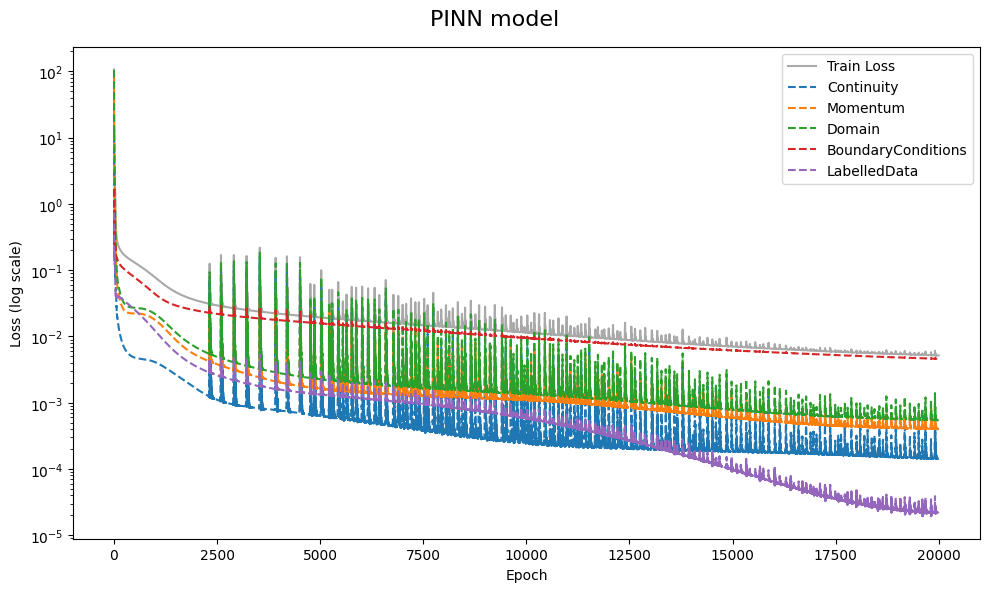

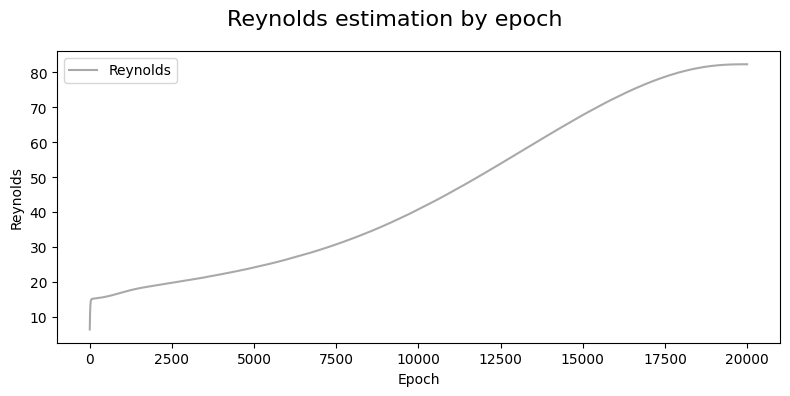

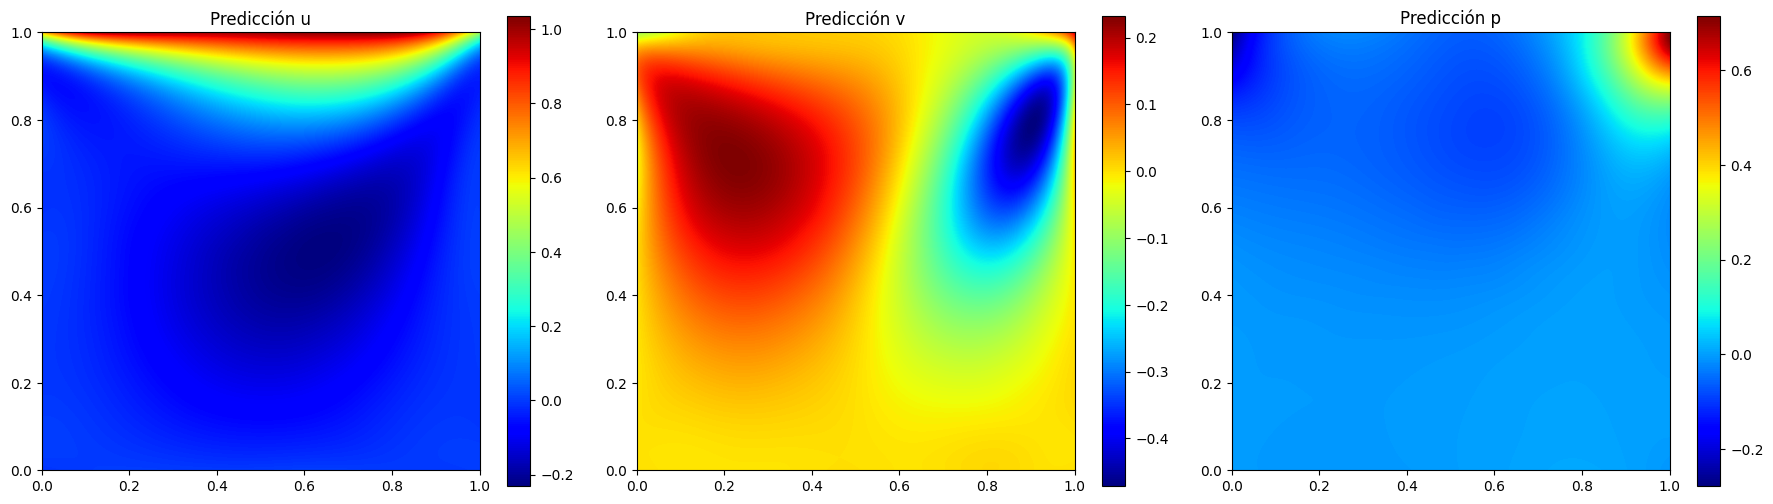

In [48]:
run_case(datasets_25)

#### 6.2 Case 2.A: Box size 0.50x0.50 without noise

Initial Reynolds Learning rate: 1.0

Epoch 500/20000
Train Loss: 5.147e-03
Continuity Train loss: 1.360e-04 Momentum Train loss: 3.943e-04
PDE Train loss: 5.303e-04 BC Train loss: 4.570e-03
Labelled Data Train Loss: 4.643e-05
Reynolds: 9.506e+01

Epoch 1000/20000
Train Loss: 6.027e-03
Continuity Train loss: 7.274e-04 Momentum Train loss: 7.511e-04
PDE Train loss: 1.479e-03 BC Train loss: 4.482e-03
Labelled Data Train Loss: 6.641e-05
Reynolds: 9.805e+01

Epoch 1500/20000
Train Loss: 5.963e-03
Continuity Train loss: 6.276e-04 Momentum Train loss: 8.568e-04
PDE Train loss: 1.484e-03 BC Train loss: 4.421e-03
Labelled Data Train Loss: 5.829e-05
Reynolds: 1.011e+02

Epoch 2000/20000
Train Loss: 8.516e-03
Continuity Train loss: 2.287e-03 Momentum Train loss: 1.741e-03
PDE Train loss: 4.029e-03 BC Train loss: 4.363e-03
Labelled Data Train Loss: 1.242e-04
Reynolds: 1.032e+02

Epoch 2500/20000
Train Loss: 1.044e-02
Continuity Train loss: 1.809e-03 Momentum Train loss: 4.068e-03
PDE Train loss: 5

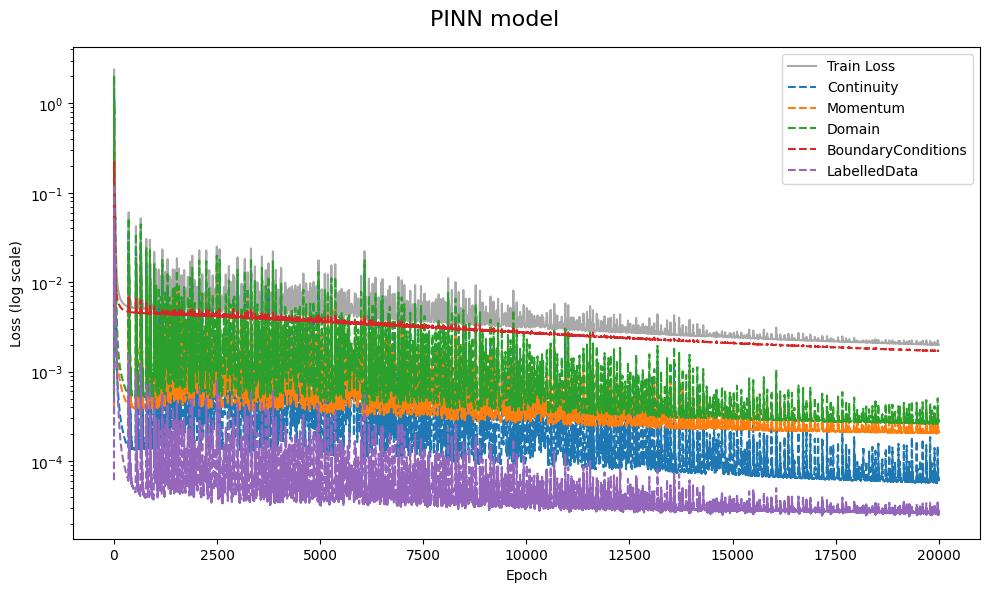

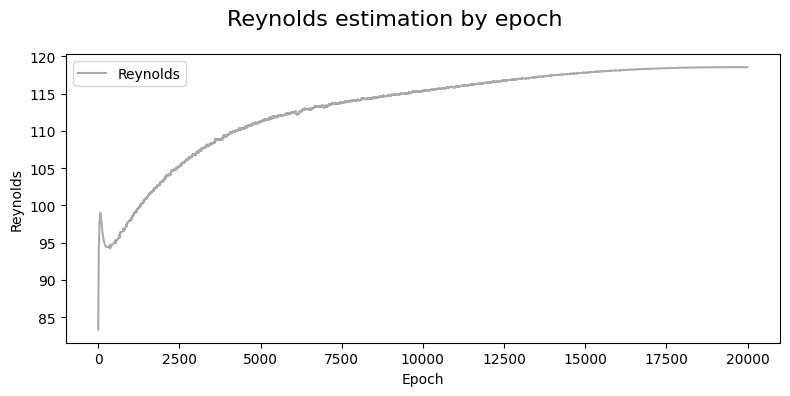

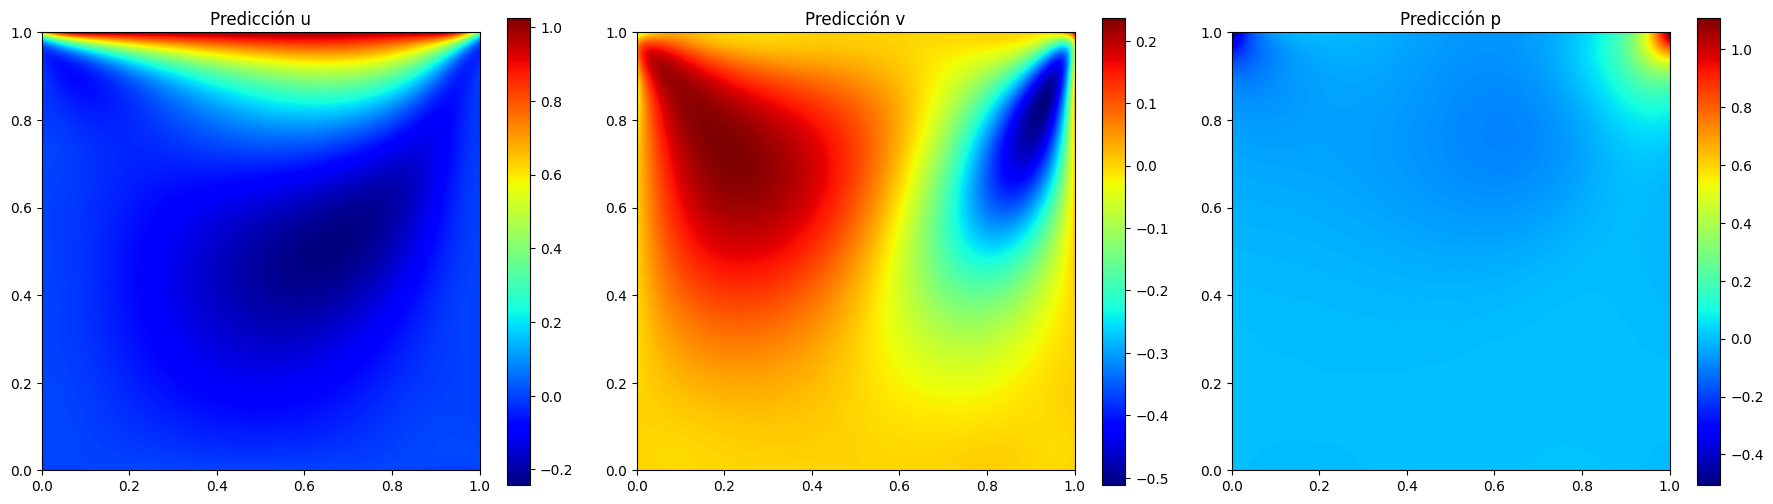

In [49]:
run_case(datasets_50)

#### 6.3 Case 3.A: Box size 0.75x0.75 without noise

Initial Reynolds Learning rate: 1.0

Epoch 500/20000
Train Loss: 2.138e-03
Continuity Train loss: 7.327e-05 Momentum Train loss: 2.153e-04
PDE Train loss: 2.886e-04 BC Train loss: 1.781e-03
Labelled Data Train Loss: 6.837e-05
Reynolds: 1.164e+02

Epoch 1000/20000
Train Loss: 2.135e-03
Continuity Train loss: 9.912e-05 Momentum Train loss: 2.404e-04
PDE Train loss: 3.395e-04 BC Train loss: 1.743e-03
Labelled Data Train Loss: 5.227e-05
Reynolds: 1.135e+02

Epoch 1500/20000
Train Loss: 3.118e-03
Continuity Train loss: 5.275e-04 Momentum Train loss: 7.230e-04
PDE Train loss: 1.250e-03 BC Train loss: 1.801e-03
Labelled Data Train Loss: 6.609e-05
Reynolds: 1.123e+02

Epoch 2000/20000
Train Loss: 5.056e-03
Continuity Train loss: 8.047e-04 Momentum Train loss: 2.289e-03
PDE Train loss: 3.094e-03 BC Train loss: 1.864e-03
Labelled Data Train Loss: 9.793e-05
Reynolds: 1.118e+02

Epoch 2500/20000
Train Loss: 5.280e-03
Continuity Train loss: 2.098e-03 Momentum Train loss: 1.253e-03
PDE Train loss: 3

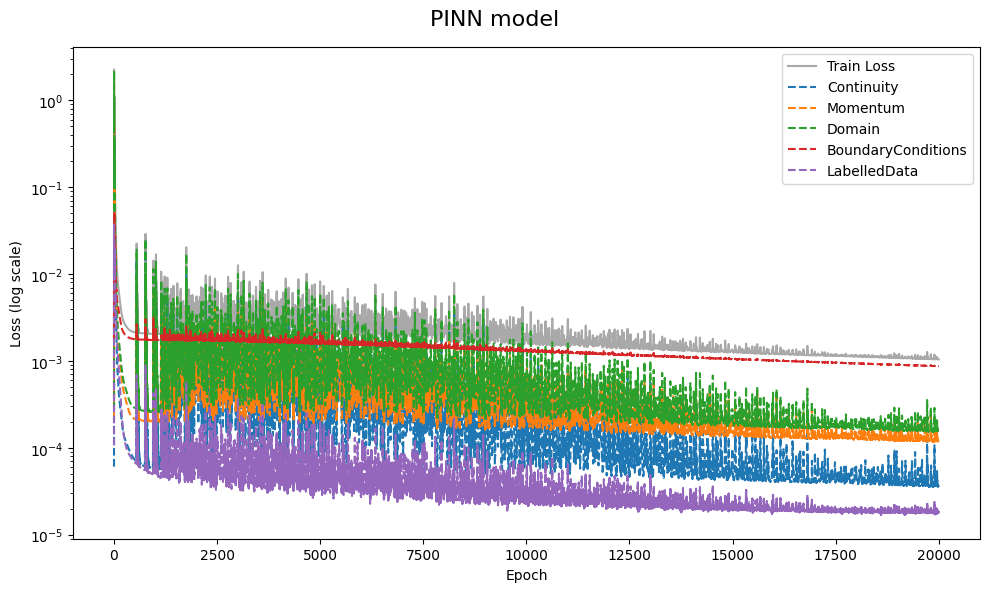

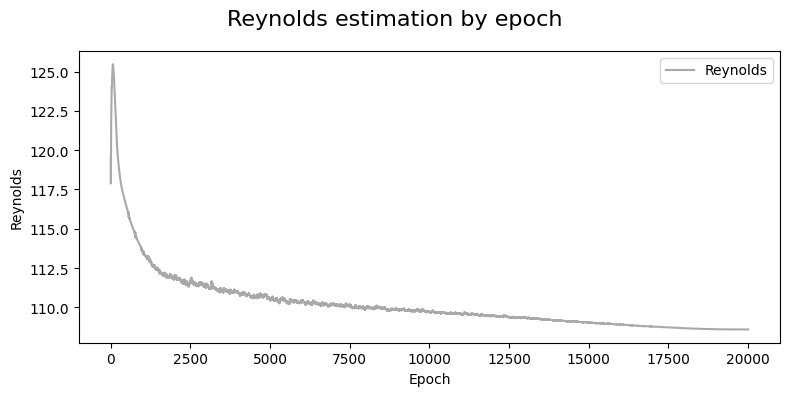

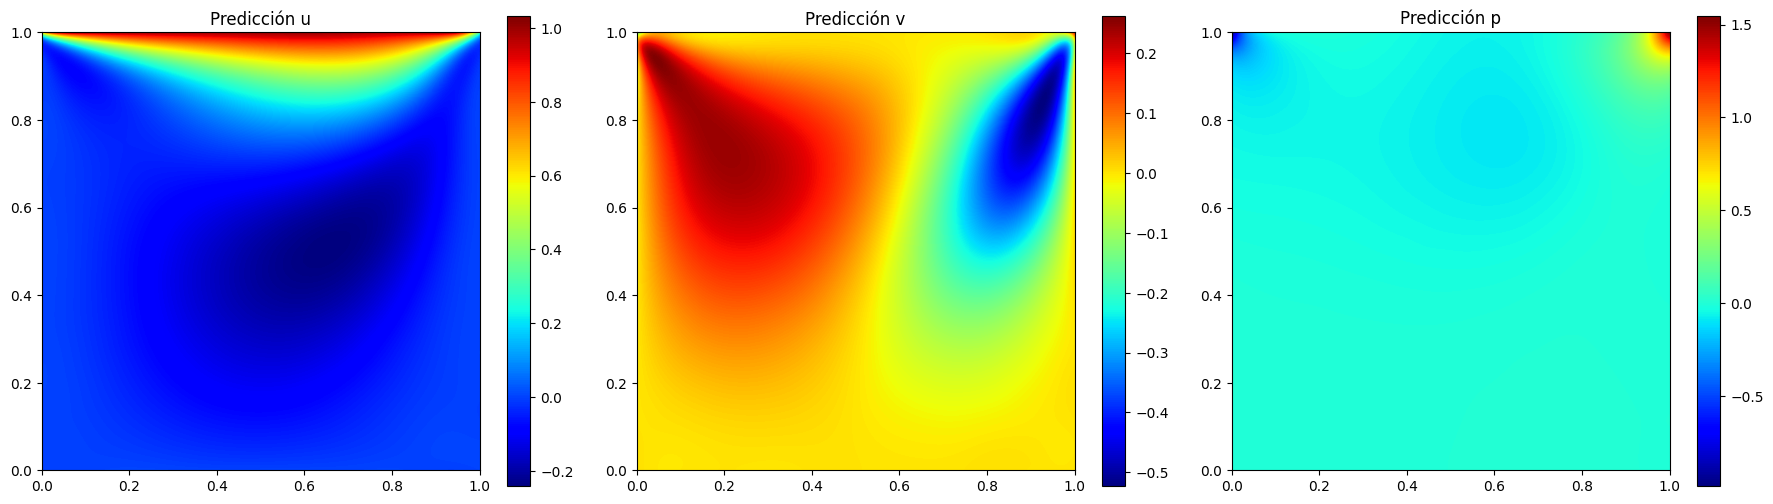

In [50]:
run_case(datasets_75)

#### 6.4 Case 1.B: Box size 0.25x0.25 with noise

Initial Reynolds Learning rate: 1.0

Epoch 500/20000
Train Loss: 4.235e-03
Continuity Train loss: 5.236e-05 Momentum Train loss: 1.760e-04
PDE Train loss: 2.284e-04 BC Train loss: 9.534e-04
Labelled Data Train Loss: 3.054e-03
Reynolds: 1.154e+02

Epoch 1000/20000
Train Loss: 5.044e-03
Continuity Train loss: 3.777e-04 Momentum Train loss: 6.024e-04
PDE Train loss: 9.801e-04 BC Train loss: 9.485e-04
Labelled Data Train Loss: 3.116e-03
Reynolds: 1.184e+02

Epoch 1500/20000
Train Loss: 6.155e-03
Continuity Train loss: 1.092e-03 Momentum Train loss: 1.007e-03
PDE Train loss: 2.099e-03 BC Train loss: 9.463e-04
Labelled Data Train Loss: 3.110e-03
Reynolds: 1.207e+02

Epoch 2000/20000
Train Loss: 5.198e-03
Continuity Train loss: 7.809e-04 Momentum Train loss: 4.472e-04
PDE Train loss: 1.228e-03 BC Train loss: 8.826e-04
Labelled Data Train Loss: 3.087e-03
Reynolds: 1.228e+02

Epoch 2500/20000
Train Loss: 5.028e-03
Continuity Train loss: 3.928e-04 Momentum Train loss: 6.176e-04
PDE Train loss: 1

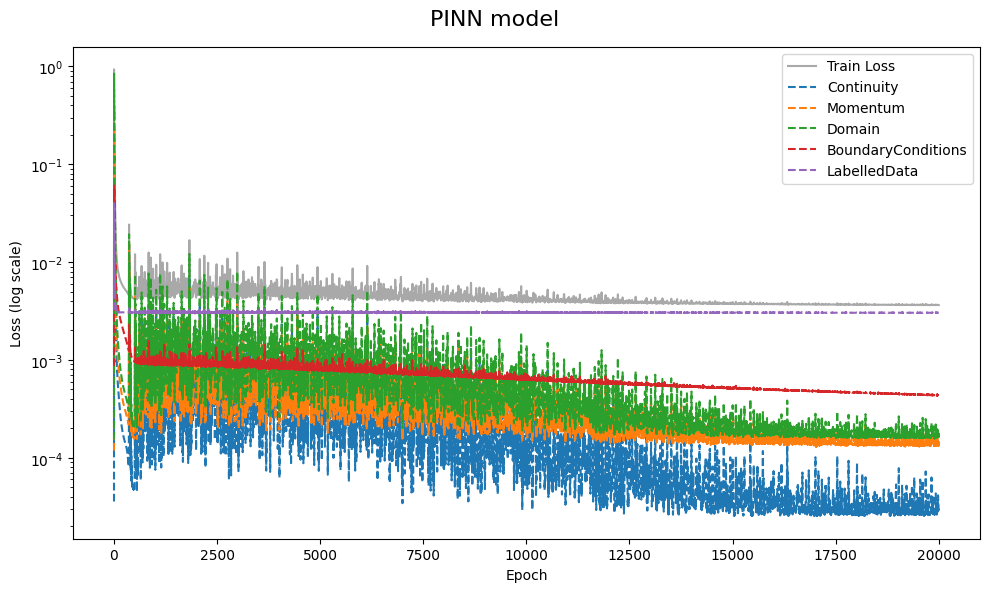

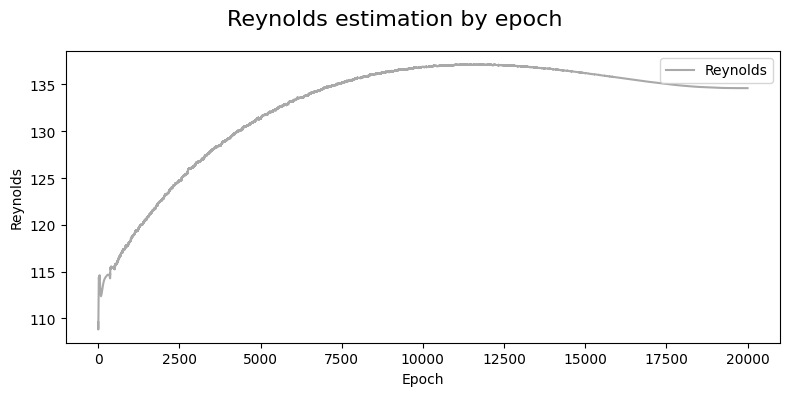

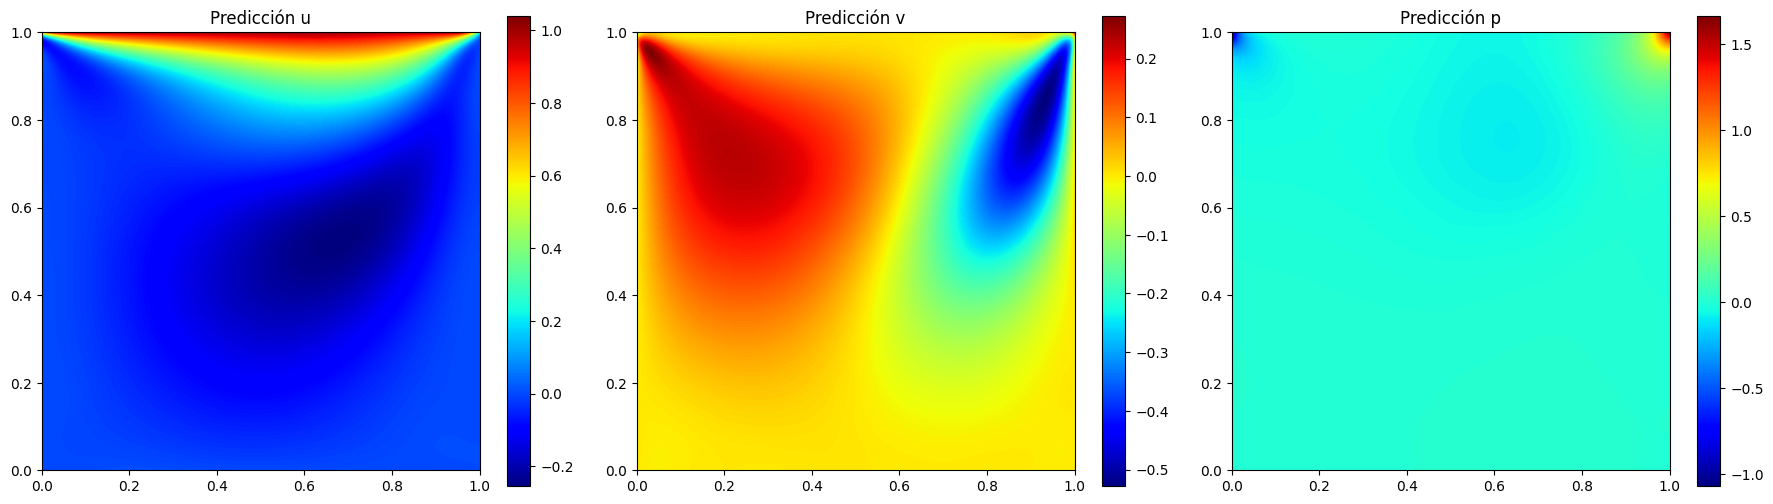

In [51]:
run_case(datasets_25_noisy)

#### 6.5 Case 2.B: Box size 0.50x0.50 with noise

Initial Reynolds Learning rate: 1.0

Epoch 500/20000
Train Loss: 9.967e-03
Continuity Train loss: 3.700e-04 Momentum Train loss: 1.209e-03
PDE Train loss: 1.579e-03 BC Train loss: 4.922e-03
Labelled Data Train Loss: 3.467e-03
Reynolds: 1.324e+02

Epoch 1000/20000
Train Loss: 8.968e-03
Continuity Train loss: 1.127e-03 Momentum Train loss: 1.460e-03
PDE Train loss: 2.587e-03 BC Train loss: 2.987e-03
Labelled Data Train Loss: 3.393e-03
Reynolds: 1.288e+02

Epoch 1500/20000
Train Loss: 6.304e-03
Continuity Train loss: 3.391e-04 Momentum Train loss: 5.409e-04
PDE Train loss: 8.800e-04 BC Train loss: 2.138e-03
Labelled Data Train Loss: 3.287e-03
Reynolds: 1.230e+02

Epoch 2000/20000
Train Loss: 5.961e-03
Continuity Train loss: 3.726e-04 Momentum Train loss: 6.240e-04
PDE Train loss: 9.966e-04 BC Train loss: 1.689e-03
Labelled Data Train Loss: 3.276e-03
Reynolds: 1.182e+02

Epoch 2500/20000
Train Loss: 5.544e-03
Continuity Train loss: 3.528e-04 Momentum Train loss: 6.086e-04
PDE Train loss: 9

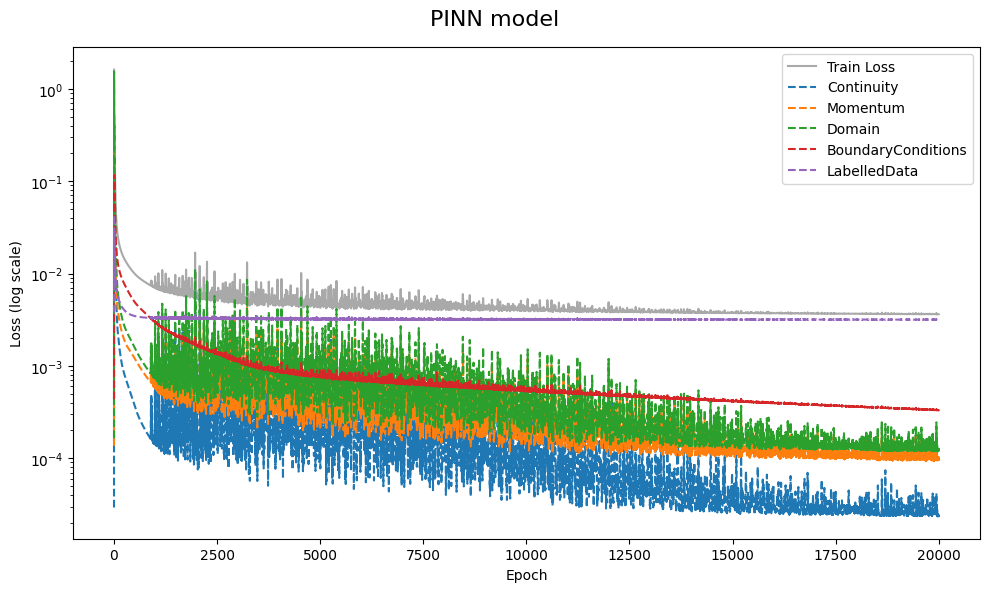

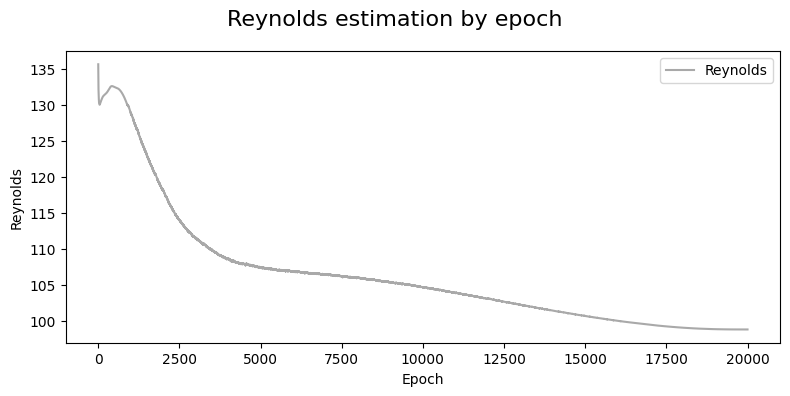

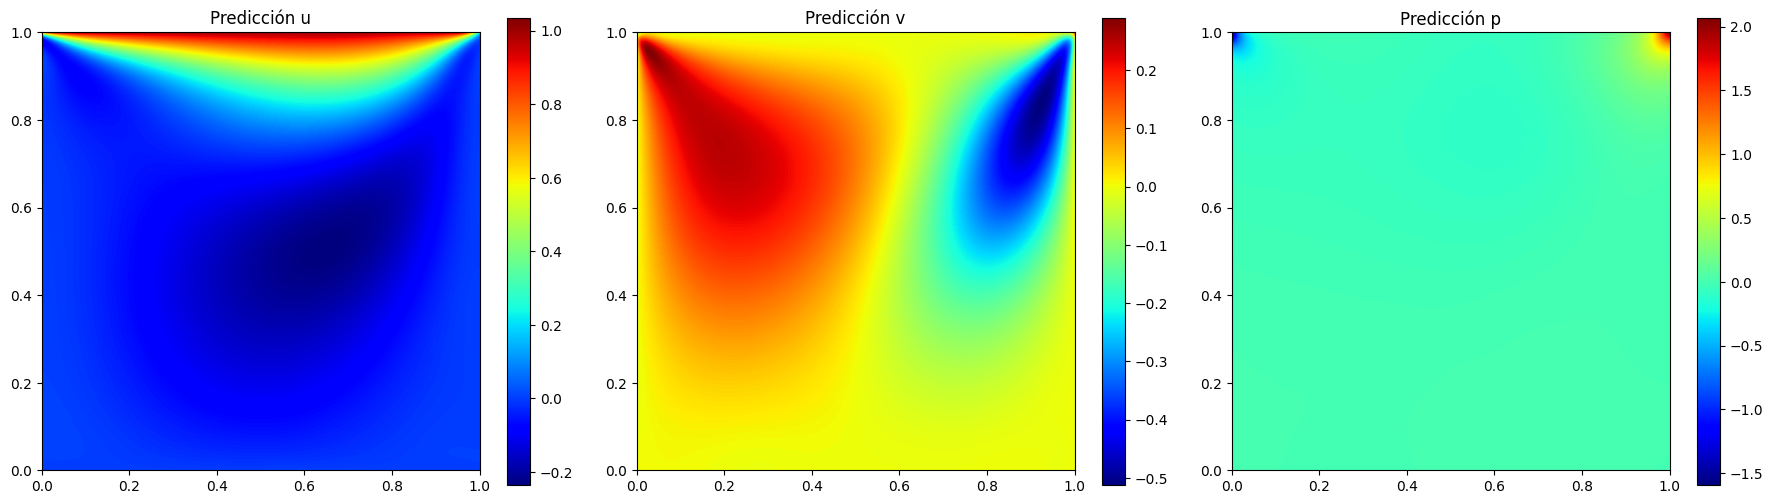

In [52]:
run_case(datasets_50_noisy)

#### 6.6 Case 3.B: Box size 0.75x0.75 with noise

Initial Reynolds Learning rate: 1.0

Epoch 500/20000
Train Loss: 6.534e-03
Continuity Train loss: 1.287e-04 Momentum Train loss: 3.502e-04
PDE Train loss: 4.789e-04 BC Train loss: 1.525e-03
Labelled Data Train Loss: 4.530e-03
Reynolds: 1.074e+02

Epoch 1000/20000
Train Loss: 6.161e-03
Continuity Train loss: 2.134e-04 Momentum Train loss: 5.104e-04
PDE Train loss: 7.238e-04 BC Train loss: 9.945e-04
Labelled Data Train Loss: 4.443e-03
Reynolds: 1.123e+02

Epoch 1500/20000
Train Loss: 6.306e-03
Continuity Train loss: 5.294e-04 Momentum Train loss: 6.671e-04
PDE Train loss: 1.196e-03 BC Train loss: 6.787e-04
Labelled Data Train Loss: 4.431e-03
Reynolds: 1.149e+02

Epoch 2000/20000
Train Loss: 5.980e-03
Continuity Train loss: 1.441e-04 Momentum Train loss: 9.878e-04
PDE Train loss: 1.132e-03 BC Train loss: 5.239e-04
Labelled Data Train Loss: 4.324e-03
Reynolds: 1.164e+02

Epoch 2500/20000
Train Loss: 5.831e-03
Continuity Train loss: 2.497e-04 Momentum Train loss: 8.134e-04
PDE Train loss: 1

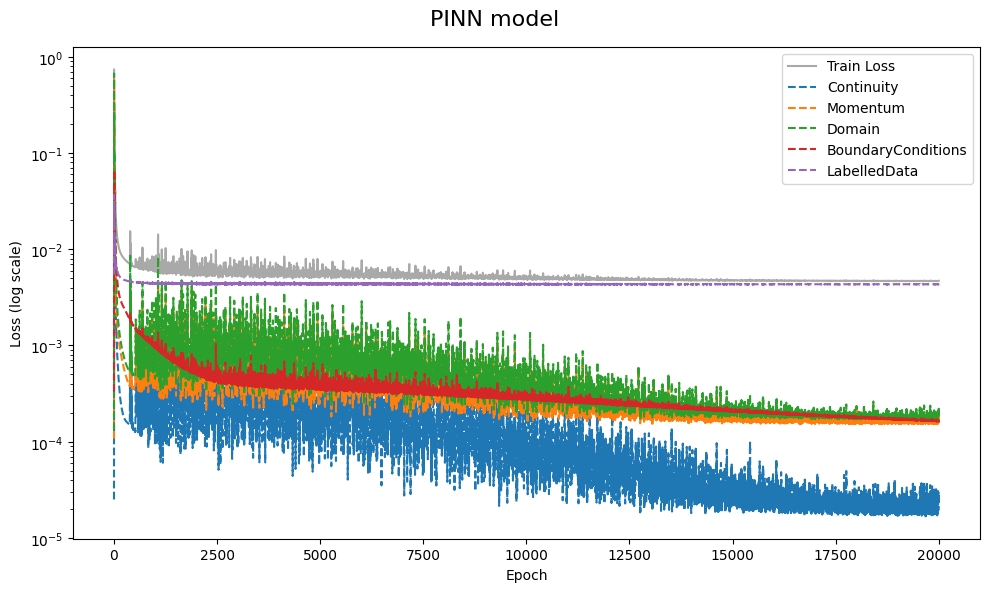

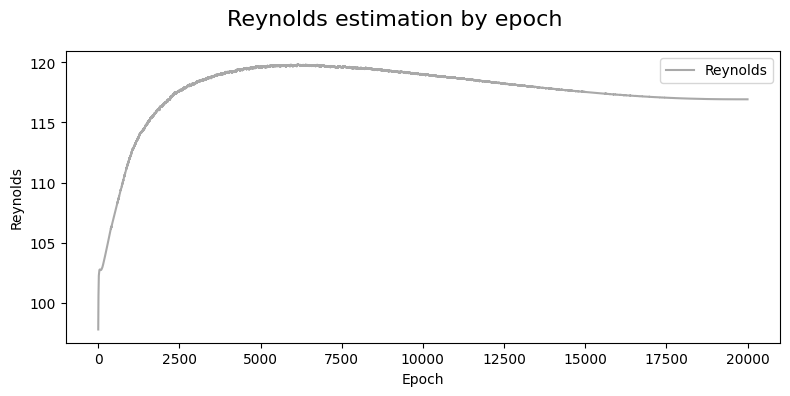

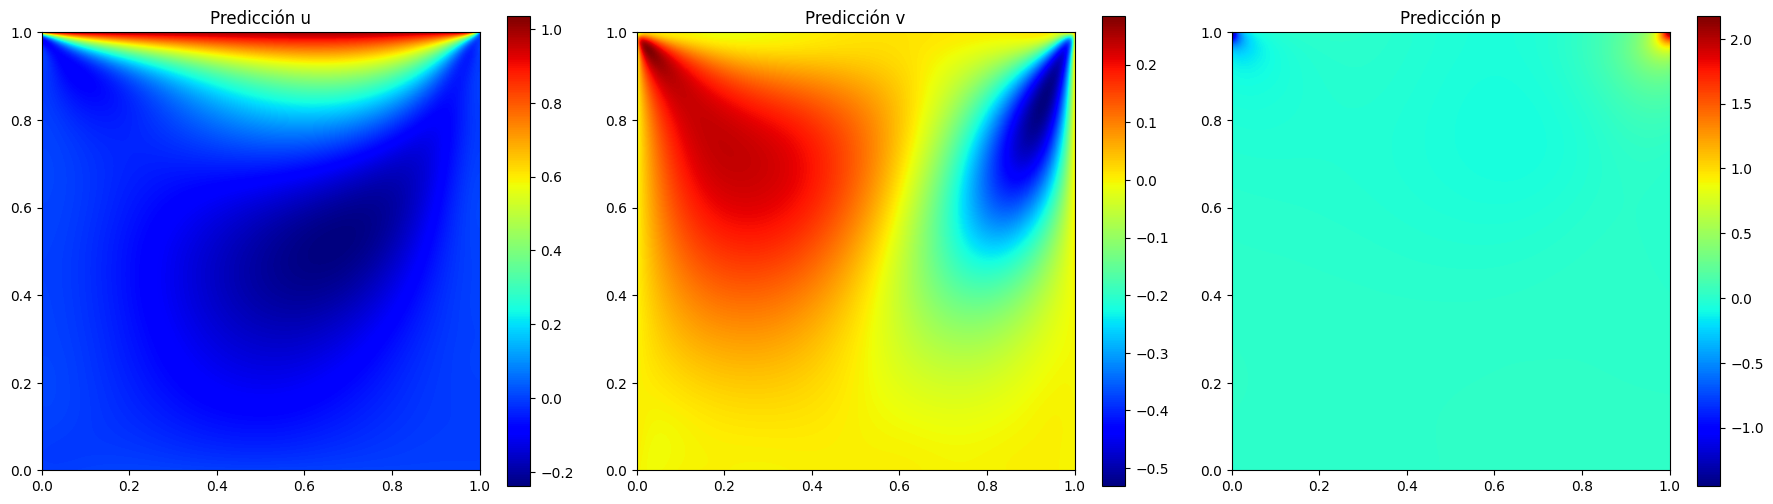

In [53]:
run_case(datasets_75_noisy)

#### 6.7 Comparación de resultados

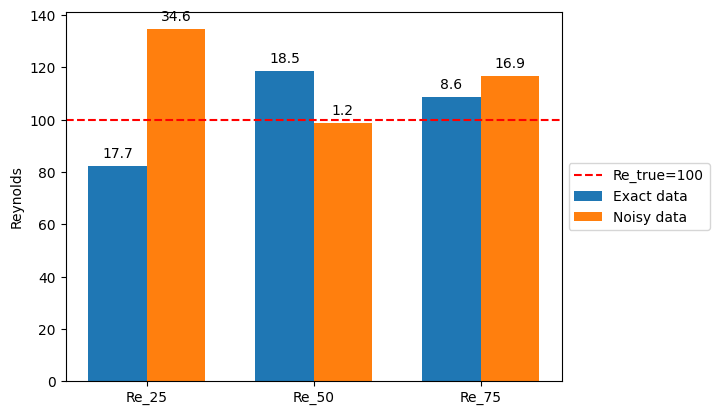

In [65]:
# Resultados
Re_1a = 8.234e+01
Re_2a = 1.185e+02
Re_3a = 1.086e+02

Re_1b = 1.346e+02
Re_2b = 9.878e+01
Re_3b = 1.169e+02

# DataFrame
results = {
    'Re': ['Re_25', 'Re_50', 'Re_75', 'Re_25_noisy', 'Re_50_noisy', 'Re_75_noisy'],
    'Valor': [Re_1a, Re_2a, Re_3a, Re_1b, Re_2b, Re_3b]
}
df_reynolds = pd.DataFrame(results)

# Agrupamos en pares
cases_pairs = [('Re_25', 'Re_25_noisy'), ('Re_50', 'Re_50_noisy'), ('Re_75', 'Re_75_noisy')]
values_pairs = []

for pair in cases_pairs:
    val1 = df_reynolds.loc[df_reynolds['Re'] == pair[0], 'Valor'].values[0]
    val2 = df_reynolds.loc[df_reynolds['Re'] == pair[1], 'Valor'].values[0]
    values_pairs.append([val1, val2])

# Convertir a array para facilitar
values_pairs = np.array(values_pairs)

# Configuración para graficar
x = np.arange(len(cases_pairs))
width = 0.35
Re_true = 100  # valor de referencia

# Solo valores
vals1 = values_pairs[:, 0]
vals2 = values_pairs[:, 1]

# Líneas de error (dentro de la barra), calculamos error respecto a Re_true
error1 = np.abs(vals1 - Re_true)
error2 = np.abs(vals2 - Re_true)

# Plot
fig, ax = plt.subplots()

# Barras agrupadas
bars1 = ax.bar(x - width/2, vals1, width, label='Exact data')
bars2 = ax.bar(x + width/2, vals2, width, label='Noisy data')

# Etiquetas de error dentro de cada barra (parte superior)
for i in range(len(x)):
    ax.text(x[i] - width/2, vals1[i] + 2, f'{error1[i]:.1f}', ha='center', va='bottom')
    ax.text(x[i] + width/2, vals2[i] + 2, f'{error2[i]:.1f}', ha='center', va='bottom')

# Línea horizontal en Re_true=100
ax.axhline(y=Re_true, color='r', linestyle='--', label='Re_true=100')

# Configuración
ax.set_xticks(x)
ax.set_xticklabels([f'Re_{p}' for p in ['25', '50', '75']])
ax.set_ylabel('Reynolds')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### 7. Conclusiones

- En términos generales, se observa que a mayor tamaño del box donde se enmarco la grilla de monitores, mejor fue la estimación del número de Reynolds. Esto resulta lógico, pues se tiene un mejor mapeo del dominio y contribuye a que la estimación sea más general. Esto se evidencia con el hecho de que tanto para el caso con ruido como sin ruido, la estimación ha sido buena.

- Se observa también que la influencia del ruido es mayor conforme el tamaño de la grilla de monitores fue menor.

- Otro punto interesante a observar es que se requieren un gran número de epochs para alcanzar una convergencia. En este caso, se utilizaron 20k epochs y, observando los gráficos, se observa que recién al final se obtiene un valor estable. Sería recomendable correr al menos unas 5 o 10k epochs más para reafirmar la convergencia a un valor.

- Se continua observando la dificultad en el campo de presiones, sobretodo en los puntos (0,1) y (1,1) donde parece haber una singularidad. Una estrategia para mejorar eso sería refinar con más puntos esas zonas localizadas.

- Como conclusión final, cuanto más abarcativa es la grilla de monitores dentro del dominio, mejor es la estimación del parámetro y menos sensible es el resultado al ruido.